In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydrake.all import (
    ModelVisualizer,
    StartMeshcat,
    Simulator,
    DiagramBuilder,
    StateInterpolatorWithDiscreteDerivative,
    JointSliders,
)
import pydot

from IPython.display import SVG, display
from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
import matplotlib.pyplot as plt
import numpy as np

import sponana.utils

In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [4]:
inspect_spot_model = False

if inspect_spot_model:
    # Inspecting the Spot Model
    visualizer = ModelVisualizer(meshcat=meshcat)
    sponana.utils.configure_parser(visualizer.parser())
    visualizer.AddModels(
        url="package://manipulation/spot/spot_with_arm_and_floating_base_actuators.urdf"
    )
    visualizer.Run(loop_once=not running_as_notebook)
    meshcat.DeleteAddedControls()

In [48]:
def create_scene(scenario_data: str):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(
        MakeHardwareStation(
            scenario, meshcat, parser_preload_callback=sponana.utils.configure_parser
        )
    )

    controller_plant = station.GetSubsystemByName(
        "spot.controller"
    ).get_multibody_plant_for_control()

    # Pose Sliders
    teleop = builder.AddSystem(
        JointSliders(
            meshcat,
            controller_plant,
            controller_plant.GetPositions(controller_plant.CreateDefaultContext()),
            step=0.05,
            decrement_keycodes=["ArrowLeft", "ArrowDown", "KeyA"] + [""] * 7,
            increment_keycodes=["ArrowRight", "ArrowUp", "KeyD"] + [""] * 7,
        )
    )

    desired_state_from_position = builder.AddSystem(
        StateInterpolatorWithDiscreteDerivative(
            10, 0.05, suppress_initial_transient=True
        )
    )
    builder.Connect(
        teleop.get_output_port(), desired_state_from_position.get_input_port()
    )
    builder.Connect(
        desired_state_from_position.get_output_port(),
        station.GetInputPort("spot.desired_state"),
    )

    diagram = builder.Build()
    return station, diagram

In [55]:
def run_simulation(scenario_data, finish_time=2.0):
    station, diagram = create_scene(scenario_data)
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.0)

    if finish_time <= 0:
        # keep simulation running
        meshcat.AddButton("Stop Simulation", "Escape")
        print("Press Escape to stop the simulation")
        while meshcat.GetButtonClicks("Stop Simulation") < 1:
            simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)
        meshcat.DeleteButton("Stop Simulation")
    else:
        # run similator for a fixed duration and publish recording
        meshcat.StartRecording()
        simulator.AdvanceTo(finish_time)
        meshcat.PublishRecording()
    return station, diagram, simulator

In [56]:
scenario_data = """
cameras:
    spot_camera:
        name: camera0
        depth: True
        X_PB:
            translation: [0, 0.01, 0]
            base_frame: camera0::base
            rotation: !Rpy { deg: [40, 180, 180] }

directives:
- add_model:
    name: spot
    file: package://manipulation/spot/spot_with_arm_and_floating_base_actuators.urdf
    default_joint_positions:
        arm_sh1: [-3.1]
        arm_el0: [3.1]
    
- add_model:
    name: banana
    file: package://sponana/banana/banana.sdf
    default_free_body_pose:
        banana:
            # move it in front of Spot 
            translation: [0.45, 0, 0.05]

- add_model:
    name: floor
    file: package://sponana/platform.sdf

- add_weld:
    parent: world
    child: floor::platform_center

- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: spot::body
    child: camera0::base
    X_PC:
        translation: [0.4, 0, 0]
        # Point slightly down towards camera
        rotation: !Rpy { deg: [-20, 0, -90] }

model_drivers:
    spot: !InverseDynamicsDriver {}
"""

In [64]:
station, diagram, simulator = run_simulation(scenario_data, finish_time=-1)

Press Escape to stop the simulation


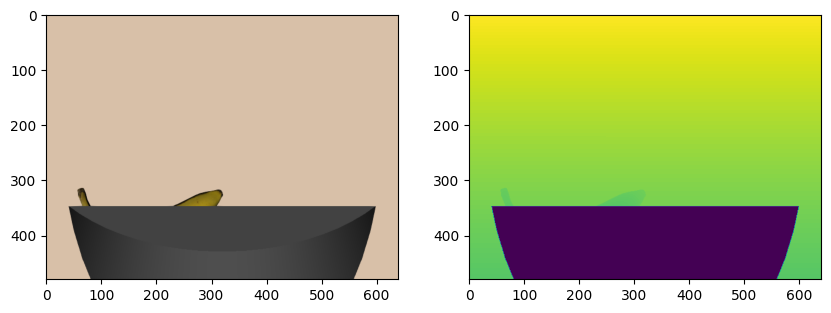

In [65]:
context = simulator.get_mutable_context()
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
depth_image = station.GetOutputPort("camera0.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

In [ ]:
display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=2))[
            0
        ].create_svg()
    )
)